In [ ]:
import os
import random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt


In [63]:
IMG_SIZE = 64
CHANNELS = 1  # grayscale

# Existing folders
DND_DIR = Path("dnd_maps")
REF_DIR = Path("map_references")

# Labels (future conditional GAN use)
LABEL_DND = 1
LABEL_REF = 0


Save paths to data folders and set constraints for them

In [64]:
def list_images(folder):
    return sorted([
        f for f in folder.iterdir()
        if f.suffix.lower() in [".png", ".jpg", ".jpeg"]
    ])

dnd_files = list_images(DND_DIR)
ref_files = list_images(REF_DIR)

print(f"DND maps: {len(dnd_files)}")
print(f"Reference maps: {len(ref_files)}")


DND maps: 1918
Reference maps: 201


create list of maps

In [65]:
def load_map_image(path, size=64):
    img = Image.open(path).convert("L")  # grayscale
    img = img.resize((size, size), Image.BILINEAR)

    img = np.array(img, dtype=np.float32) / 255.0
    return img


load in maps

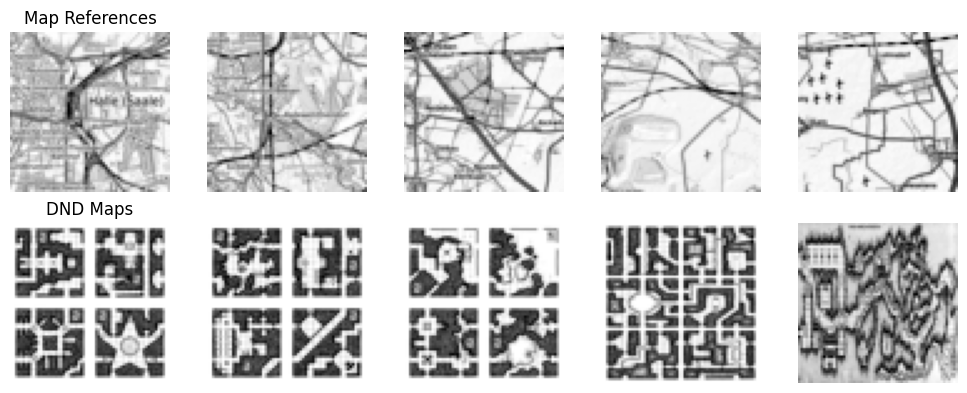

In [66]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

for i in range(5):
    dnd_img = load_map_image(dnd_files[i])
    ref_img = load_map_image(ref_files[i])

    axs[0, i].imshow(ref_img, cmap="gray")
    axs[0, i].axis("off")

    axs[1, i].imshow(dnd_img, cmap="gray")
    axs[1, i].axis("off")

axs[0, 0].set_title("Map References")
axs[1, 0].set_title("DND Maps")

plt.tight_layout()
plt.show()


check to see if maps load correctly

In [67]:
Image.MAX_IMAGE_PIXELS = None  # allow very large images

class MapDataset(Dataset):
    def __init__(self, dnd_dir, ref_dir, img_size=256):
        self.dnd_dir = dnd_dir
        self.ref_dir = ref_dir
        self.dnd_files = os.listdir(dnd_dir)
        self.ref_files = os.listdir(ref_dir)
        self.length = min(len(self.dnd_files), len(self.ref_files))
        
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        dnd_path = os.path.join(self.dnd_dir, self.dnd_files[idx])
        ref_path = os.path.join(self.ref_dir, self.ref_files[idx])
        
        dnd_img = Image.open(dnd_path).convert('RGB')
        ref_img = Image.open(ref_path).convert('RGB')
        
        dnd_img = self.transform(dnd_img)
        ref_img = self.transform(ref_img)
        
        return dnd_img, ref_img


Class for loading individual map datasets

In [68]:
dataset = MapDataset(DND_DIR, REF_DIR)

loader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0  # IMPORTANT for Jupyter + Windows
)

images, labels = next(iter(loader))

print("Batch shape:", images.shape)
print("Labels:", labels)


Batch shape: torch.Size([8, 1, 256, 256])
Labels: tensor([[[[ 0.2784, -0.0039, -0.2471,  ...,  0.3098,  0.9843,  0.8039],
          [-0.9608, -0.9843, -0.6784,  ...,  0.0902,  0.9843,  0.9843],
          [ 0.0824,  0.5843,  0.5843,  ...,  0.1529,  0.0902, -0.4039],
          ...,
          [ 0.5686, -0.0745,  0.3098,  ...,  0.9843,  0.6784, -0.4196],
          [ 0.5686,  0.0275,  0.0275,  ...,  0.9843,  0.5686, -0.5294],
          [ 0.6941, -0.0275,  0.1529,  ...,  0.9843,  0.4431, -0.4667]]],


        [[[ 0.9294,  0.9294,  0.9294,  ...,  0.9294,  0.9294,  0.9294],
          [ 0.9294,  0.9294,  0.9294,  ...,  0.9294,  0.9294,  0.9294],
          [ 0.9294,  0.9294,  0.9294,  ...,  0.9294,  0.9294,  0.9294],
          ...,
          [ 0.7098,  0.4745,  0.1922,  ...,  0.9294,  0.9294,  0.9294],
          [ 0.7647, -0.1294,  0.1922,  ...,  0.9294,  0.9294,  0.9294],
          [ 0.6078,  0.0353,  0.7333,  ...,  0.9451,  0.9451,  0.9451]]],


        [[[ 0.7725,  0.7725,  0.7725,  ...,  0.1

find map data shape

GAN model

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


set device to cpu

In [70]:
class ConditionalGenerator(nn.Module):
    def __init__(self, z_dim=50, in_channels=1, out_channels=1):
        super().__init__()
        self.z_dim = z_dim
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels + z_dim, 64, kernel_size=4, stride=2, padding=1),  # input: reference + latent
            nn.ReLU(True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, ref_map, z):
        # z: (batch, z_dim), reshape to (batch, z_dim, H, W)
        batch_size, _, H, W = ref_map.shape
        z_map = z.view(batch_size, self.z_dim, 1, 1).expand(batch_size, self.z_dim, H, W)
        
        x = torch.cat([ref_map, z_map], dim=1)  # concatenate along channels
        return self.model(x)


conditional generator

In [71]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels*2, 64, kernel_size=4, stride=2, padding=1),  # ref + real/fake
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten(),
            nn.Linear(128*64*64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, map_input, ref_map):
        x = torch.cat([map_input, ref_map], dim=1)
        return self.model(x)


conditional descriminator

In [77]:
# Hyperparameters
batch_size = 8
num_epochs = 60  # increase slowly for stability
lr = 1e-4  # smaller learning rate
noise_std = 0.05  # Gaussian noise for D inputs
clip_grad = True  # gradient clipping option
lambda_l1 = 100  # weight for L1 loss in generator

# Initialize models
G = ConditionalGenerator(z_dim=50).to(device)
D = ConditionalDiscriminator().to(device)

# Optimizers and loss
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
criterion_bce = nn.BCELoss()
criterion_l1 = nn.L1Loss()

# DataLoader
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

for epoch in range(num_epochs):
    for i, (real_maps, ref_maps) in enumerate(loader):
        real_maps = real_maps.to(device)
        ref_maps = ref_maps.to(device)
        b_size = real_maps.size(0)  # batch size (may be smaller for last batch)

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Label smoothing
        real_labels = torch.ones(b_size, 1, device=device) * 0.9
        fake_labels = torch.zeros(b_size, 1, device=device) + 0.1

        # Add Gaussian noise to inputs
        real_maps_noisy = real_maps + noise_std * torch.randn_like(real_maps)

        # Real maps
        outputs_real = D(real_maps_noisy, ref_maps)
        d_loss_real = criterion_bce(outputs_real, real_labels)

        # Fake maps
        z = torch.randn(b_size, G.z_dim, device=device)  # <-- match batch size
        fake_maps = G(ref_maps, z)
        fake_maps_noisy = fake_maps.detach() + noise_std * torch.randn_like(fake_maps)
        outputs_fake = D(fake_maps_noisy, ref_maps)
        d_loss_fake = criterion_bce(outputs_fake, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()

        if clip_grad:
            torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=5)
        optimizer_D.step()

        # ---------------------
        # Train Generator
        # ---------------------
        optimizer_G.zero_grad()
        outputs_fake_for_G = D(fake_maps, ref_maps)
        adv_loss = criterion_bce(outputs_fake_for_G, real_labels)  # adversarial loss to fool D

        l1_loss = criterion_l1(fake_maps, real_maps)  # L1 loss to real maps

        g_loss = adv_loss + lambda_l1 * l1_loss  # combined generator loss

        g_loss.backward()

        if clip_grad:
            torch.nn.utils.clip_grad_norm_(G.parameters(), max_norm=5)
        optimizer_G.step()

        # Logging
        if i % 13 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(loader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, L1 Loss: {l1_loss.item():.4f}")

    # ---------------------
    # Save sample images safely
    # ---------------------
    with torch.no_grad():
        # Take up to 4 samples from the last batch
        ref_sample = ref_maps[:4]
        sample_z = torch.randn(ref_sample.size(0), G.z_dim, device=device)  # match batch size
        fake_maps_sample = G(ref_sample, sample_z).cpu()
    save_image((fake_maps_sample + 1)/2, f"samples_epoch_{epoch+1}.png")


Epoch [1/60], Step [0/26], D Loss: 1.4735, G Loss: 104.5056, L1 Loss: 0.9284
Epoch [1/60], Step [13/26], D Loss: 1.4741, G Loss: 87.6339, L1 Loss: 0.8709
Epoch [2/60], Step [0/26], D Loss: 3.8904, G Loss: 89.0987, L1 Loss: 0.8241
Epoch [2/60], Step [13/26], D Loss: 4.8774, G Loss: 81.9853, L1 Loss: 0.7534
Epoch [3/60], Step [0/26], D Loss: 3.7657, G Loss: 70.6893, L1 Loss: 0.6583
Epoch [3/60], Step [13/26], D Loss: 1.4367, G Loss: 63.7819, L1 Loss: 0.6320
Epoch [4/60], Step [0/26], D Loss: 3.6168, G Loss: 68.8390, L1 Loss: 0.6495
Epoch [4/60], Step [13/26], D Loss: 2.6526, G Loss: 70.4421, L1 Loss: 0.6525
Epoch [5/60], Step [0/26], D Loss: 2.7443, G Loss: 64.6430, L1 Loss: 0.5993
Epoch [5/60], Step [13/26], D Loss: 2.7949, G Loss: 63.4973, L1 Loss: 0.5806
Epoch [6/60], Step [0/26], D Loss: 1.7706, G Loss: 65.0889, L1 Loss: 0.5648
Epoch [6/60], Step [13/26], D Loss: 2.9526, G Loss: 61.4824, L1 Loss: 0.5419
Epoch [7/60], Step [0/26], D Loss: 1.6135, G Loss: 69.8993, L1 Loss: 0.5985
Epoch

training loops with each model focussed on minimizing loss

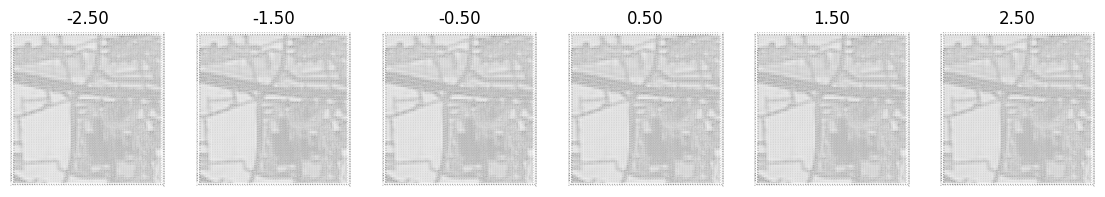

In [78]:
# Fixed reference map
ref_map_single = ref_maps[0:1].to(device)

# Base latent vector
base_z = torch.randn(1, G.z_dim, device=device)

# Sweep one latent dimension
latent_dim = 0  # change this to explore others
values = torch.linspace(-2.5, 2.5, 6)

generated = []

with torch.no_grad():
    for v in values:
        z_var = base_z.clone()
        z_var[0, latent_dim] = v
        img = G(ref_map_single, z_var).cpu()
        generated.append((img[0, 0] + 1) / 2)

# Plot
plt.figure(figsize=(14, 3))
for i, img in enumerate(generated):
    plt.subplot(1, len(values), i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{values[i]:.2f}")
    plt.axis("off")
plt.show()


show latent dimensions for map

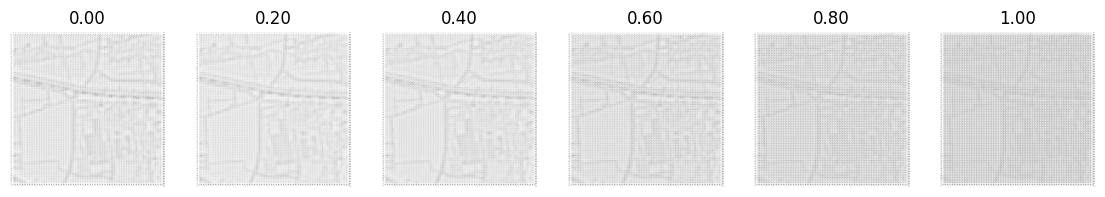

In [79]:
G.eval()

# Safely grab ONE reference map (always batch size = 1)
ref_map_single = ref_maps[0:1].to(device)  # shape [1, 1, H, W]

# Two latent vectors
z1 = torch.randn(1, G.z_dim, device=device)
z2 = torch.randn(1, G.z_dim, device=device)

num_steps = 6
alphas = torch.linspace(0, 1, num_steps)

generated = []

with torch.no_grad():
    for a in alphas:
        z_interp = (1 - a) * z1 + a * z2
        img = G(ref_map_single, z_interp).cpu()
        generated.append((img[0, 0] + 1) / 2)  # scale to [0,1]

# Plot
plt.figure(figsize=(14, 3))
for i, img in enumerate(generated):
    plt.subplot(1, num_steps, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{alphas[i]:.2f}")
    plt.axis("off")
plt.show()


show latent interpolation for dnd map